# Math 86 Final Project

## Comparing AMM's

### Alex Craig, Wanxin Hu, Ganqi Li, Fangzhou Yu

## Part 1. Simple AMM

The simple AMM follows the model $xy = k$, where $k$ remains constant assuming no liquidity is provided or removed. Let's instantiate a simple AMM and see how it behaves.

### 1.1 Simple AMM Price Curve

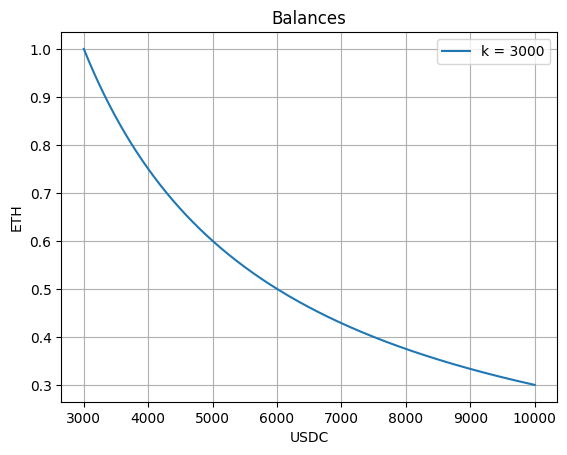

In [1]:
from simulations.uniswapV2 import UniswapV2
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

initial_x = 3000
initial_y = 1

delta = 1
x_max = 10000

simple = UniswapV2(0.0003, initial_x, initial_y)

simple_balances = [[simple.x, simple.y]]


while simple.x < x_max:
    simple.swap_x_for_y(delta)
    simple_balances.append([simple.x, simple.y])

# Plot the balances
simple_balances = np.array(simple_balances)
plt.plot(simple_balances[:, 0], simple_balances[:, 1])
plt.title("Balances")
plt.xlabel("USDC")
plt.ylabel("ETH")
plt.grid()
plt.legend(["k = " + str(simple.k)])

plt.show()

### 1.2 Simple AMM IL Curve

In [2]:
def calculate_impermanent_loss(new_price_ratio, initial_price_ratio = 1):
    price_ratio_change = new_price_ratio / initial_price_ratio
    il = 2 * (price_ratio_change ** 0.5) / (1 + price_ratio_change) - 1
    return il * 100  # Return IL as a percentage

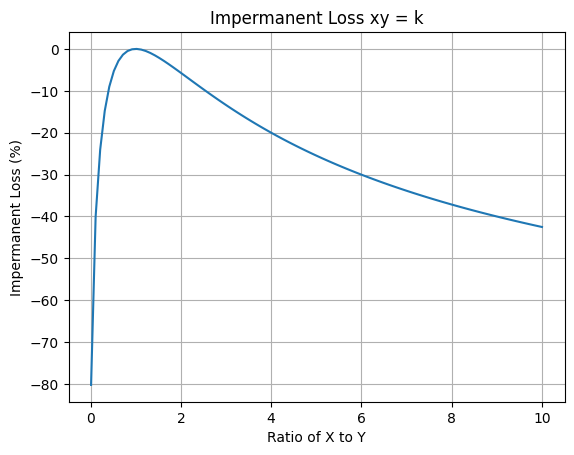

In [3]:
# Sample ratios
ratios_simple = np.linspace(0.01, 10, 100)

# Calculate the impermanent loss
impermanent_losses_simple = [calculate_impermanent_loss(r) for r in ratios_simple]

# Plot the impermanent loss
plt.plot(ratios_simple, impermanent_losses_simple)
plt.title('Impermanent Loss xy = k')
plt.xlabel('Ratio of X to Y')
plt.ylabel('Impermanent Loss (%)')
plt.grid()
plt.show()

## Part 2. Balancer

Let's plot the price curve of balancer with different weights.

### 1.1 Balancer Price Curves

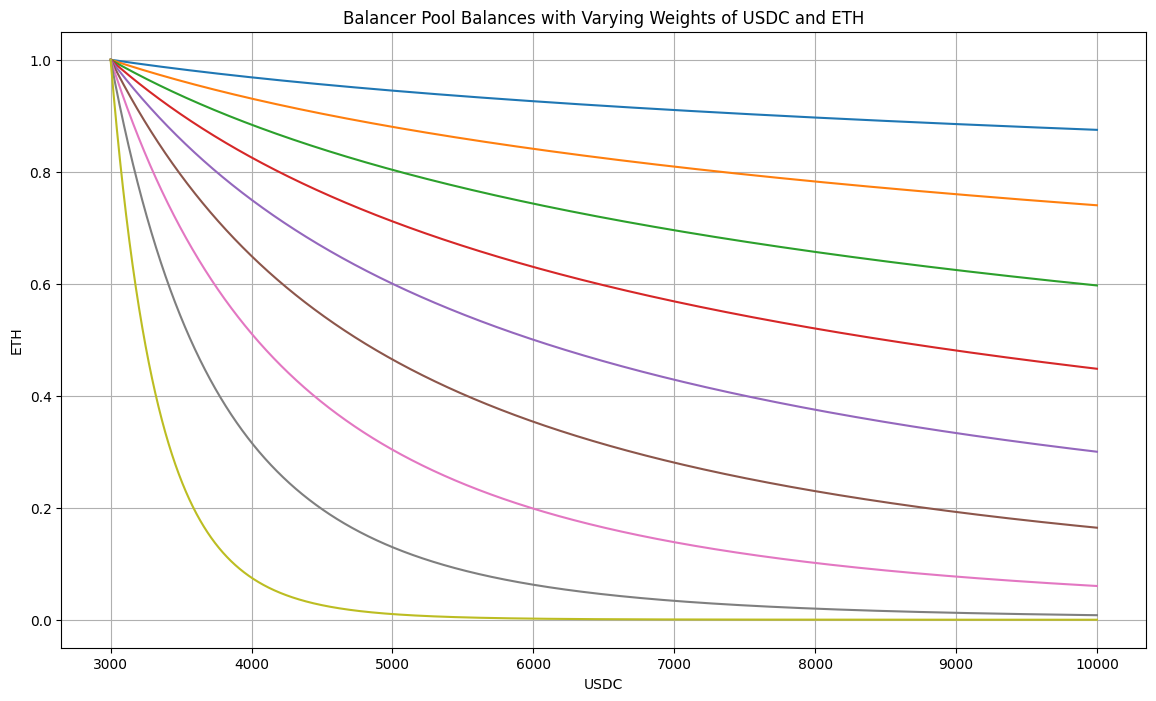

In [4]:
from simulations.balancer import Balancer

# Initialize variables
weights = np.arange(0.1, 1.0, 0.1)  # Weights
delta = 1
balances_by_weight = []

# Loop over each weight configuration
for weight_x in weights:
    weight_y = 1 - weight_x
    balancer = Balancer(initial_x, initial_y, weight_x, weight_y)
    balances = [[balancer.x, balancer.y]]
    
    while balancer.x < x_max:
        balancer.swap_x_for_y(delta)
        balances.append([balancer.x, balancer.y])
    
    balances_by_weight.append(np.array(balances))

# Plot the price curves for different weights
plt.figure(figsize=(14, 8))

for i, balances in enumerate(balances_by_weight):
    plt.plot(balances[:, 0], balances[:, 1], label=f'Weight x: {weights[i]*100:.0f}%')

plt.title('Balancer Pool Balances with Varying Weights of USDC and ETH')
plt.xlabel('USDC')
plt.ylabel('ETH')
plt.grid()
plt.legend
plt.show()

### 1.2.1 Balancer IL Curves Linear Scale

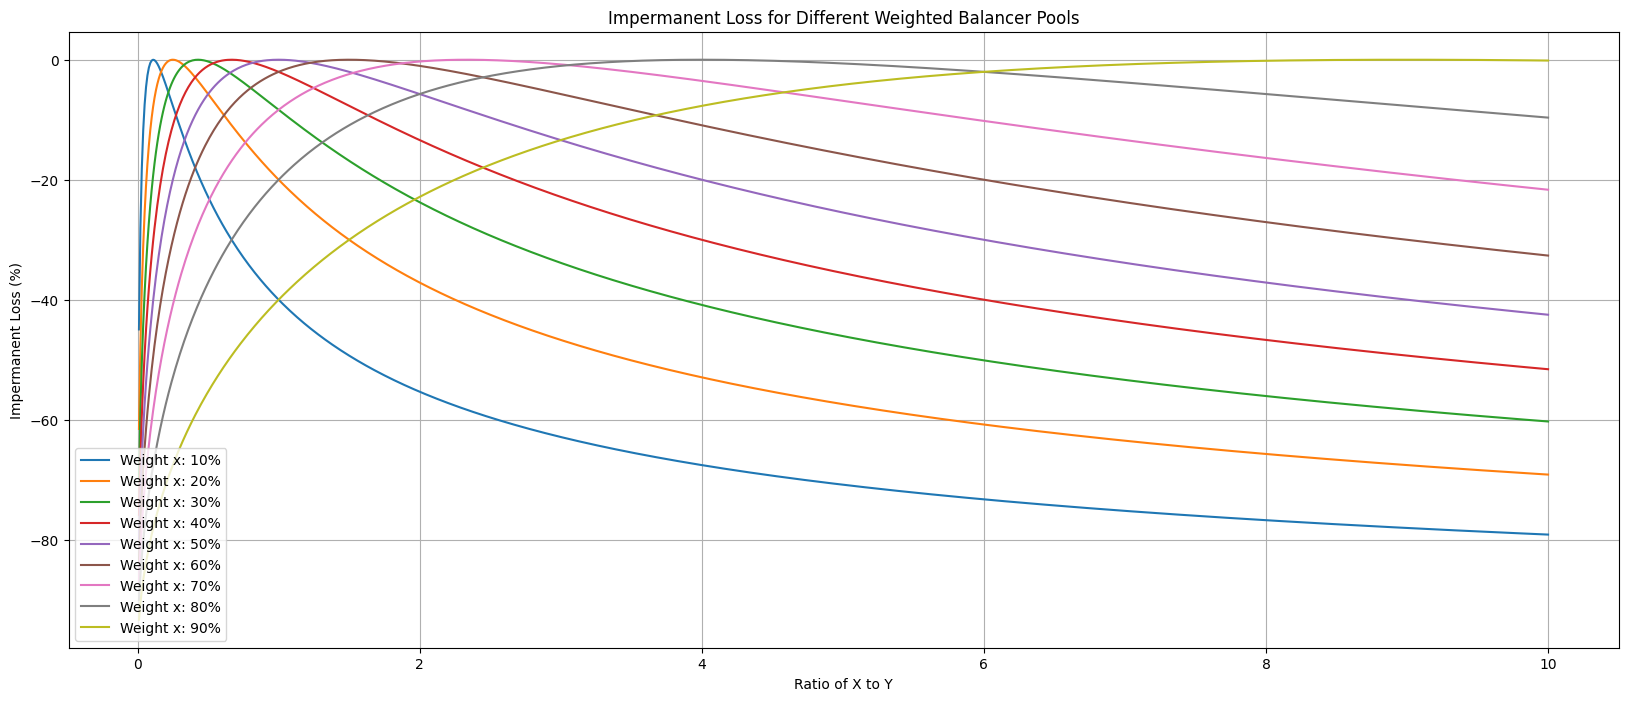

In [5]:
# Define weight configurations for Balancer pools
weights = np.arange(0.1, 1.0, 0.1)  # Weights

# Sample ratios from 0.01 to 10
ratios_balancer = np.linspace(0.01, 10, 1000)

# Calculate the impermanent loss for each weight configuration
plt.figure(figsize=(20, 8))

for weight_x in weights:
    weight_y = 1 - weight_x
    initial_price_ratio = weight_x / weight_y
    impermanent_losses_balancer = [calculate_impermanent_loss(r, initial_price_ratio) for r in ratios_balancer]
    plt.plot(ratios_balancer, impermanent_losses_balancer, label=f'Weight x: {weight_x*100:.0f}%')

plt.title('Impermanent Loss for Different Weighted Balancer Pools')
plt.xlabel('Ratio of X to Y')
plt.ylabel('Impermanent Loss (%)')
plt.grid(True)
plt.legend()
plt.show()


### 1.2.2 Balancer IL Curves Log Scale

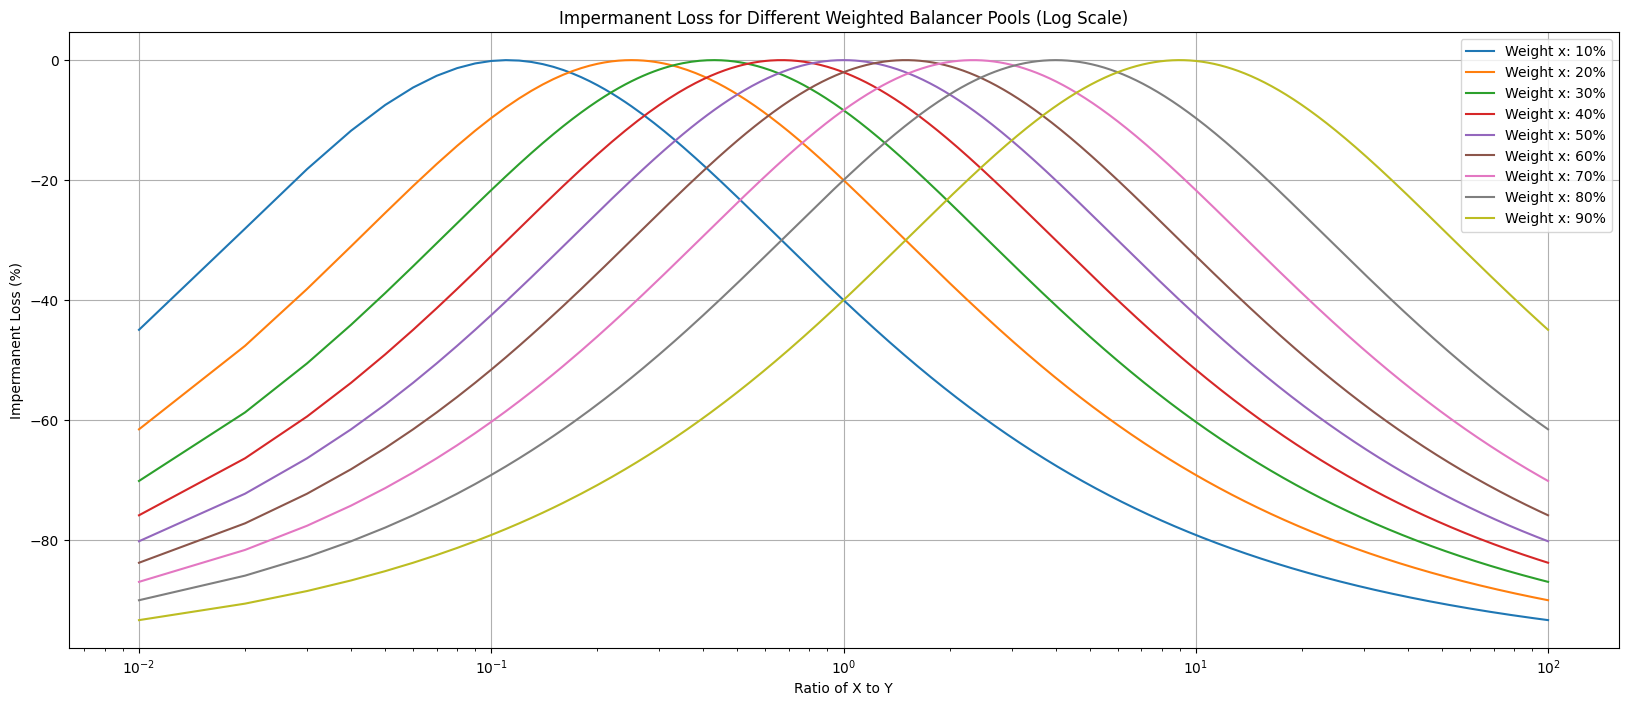

In [6]:
# Define weight configurations for Balancer pools
weights = np.arange(0.1, 1.0, 0.1)  # Weights

# Sample ratios from 0.01 to 10
ratios_balancer = np.linspace(0.01, 100, 10000)

# Calculate the impermanent loss for each weight configuration
plt.figure(figsize=(20, 8))

for weight_x in weights:
    weight_y = 1 - weight_x
    initial_price_ratio = weight_x / weight_y
    impermanent_losses_balancer = [calculate_impermanent_loss(r, initial_price_ratio) for r in ratios_balancer]
    plt.plot(ratios_balancer, impermanent_losses_balancer, label=f'Weight x: {weight_x*100:.0f}%')

plt.title('Impermanent Loss for Different Weighted Balancer Pools (Log Scale)')
plt.xlabel('Ratio of X to Y')
plt.xscale('log')
plt.ylabel('Impermanent Loss (%)')
plt.grid(True)
plt.legend()
plt.show()

## Part 3. Uniswap
As discussed in the paper, 

### 2.1.1 Uniswap v2 vs Uniswap v3 slippage

For different tvl, let's measure the slippage concentrated liquidity (v3) and constant product (v2). Based on different levels of liquidity. Note that we keep uniswap's convention and start with a 50-50 pool, which means in each pool, token x and token y each account of half the value of liquidity.

In [9]:
from simulations.uniswapV3 import UniswapV3
from simulations.uniswapV2 import UniswapV2

In [10]:
## Let current price be 3800
## Say token x is ETH and token y is USDC, and current exchange ratio is 1:3800
PRICE = 3800

tvl_list = [1*10**7, 5*10**7, 1*10**8, 5*10**8, 1*10**9]
## for v3, we need to assume a certain number of LPs
lp_list = [1000, 5000, 10000, 50000, 100000]
v3_slippage = []
v2_slippage = []

trade_volumes = [500000, 1000000, 5000000, 10000000]

for i in range(len(tvl_list)):
    v3_slippage_curr_tvl = []
    v2_slippage_curr_tvl = []
    for j in range(len(trade_volumes)):
        # initialize
        uniswap_v3 = UniswapV3(0.0003, num_lp = lp_list[i], vl_per_lp = tvl_list[i]/lp_list[i])
        x = tvl_list[i]/2/PRICE
        y = tvl_list[i]
        uniswap_v2 = UniswapV2(0.0003, x, y)

        ## Trade
        s3 = uniswap_v3.swap_y_for_x(trade_volumes[j])[1]
        s2 = uniswap_v2.swap_y_for_x(trade_volumes[j])[1]
        v3_slippage_curr_tvl.append(s3)
        v2_slippage_curr_tvl.append(s2)
    v3_slippage.append(v3_slippage_curr_tvl)
    v2_slippage.append(v2_slippage_curr_tvl)
        


current price of x to y is 3792.8775054648436
You have swapped for 117.7554790204947 token x, at the price of 3792.8775054648436, the change of price is 1.1606176377496128e-08
current price of x to y is 3792.8775054648436
You have swapped for 212.8981453205554 token x, at the price of 3792.8775054648436, the change of price is 4.620402993843588e-08
current price of x to y is 3792.8775054648436
You have swapped for 595.0528246699487 token x, at the price of 3792.8775054648436, the change of price is 1.2535384758945725e-06
current price of x to y is 3792.8775054648436
You have swapped for 775.159887142657 token x, at the price of 3792.8775054648436, the change of price is 4.7776793074494675e-06
current price of x to y is 3792.8775054648436
You have swapped for 128.74661883933732 token x, at the price of 3792.8775054648436, the change of price is 1.789507796157458e-11
current price of x to y is 3792.8775054648436
You have swapped for 251.5958140845769 token x, at the price of 3792.8775054

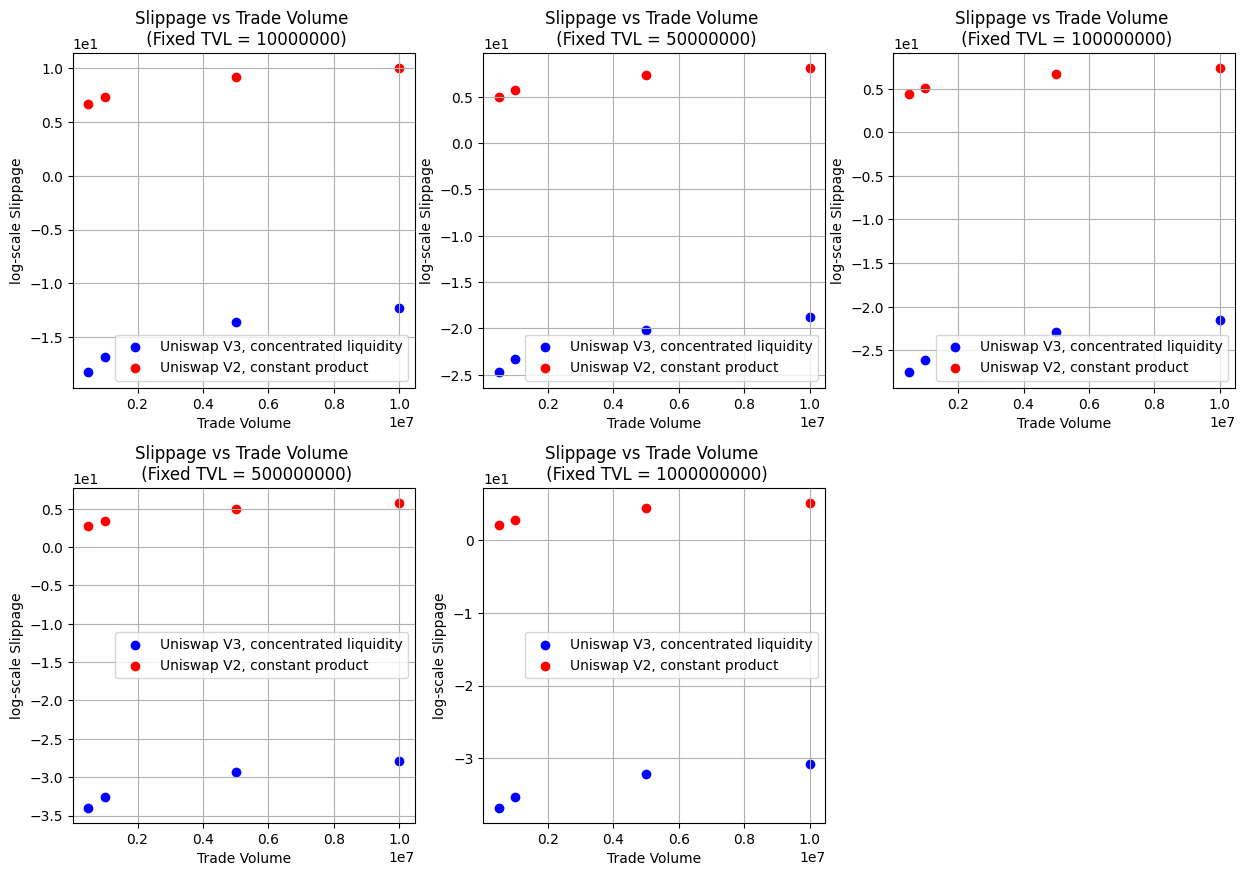

<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt

num_rows = 2
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
plt.subplots_adjust(hspace=0.3) 

for i in range(len(tvl_list)):
    row = i // num_cols
    col = i % num_cols

    plt.figure(figsize=(4, 3))
    y_1 = np.log(v3_slippage[i])
    y_2 = np.log(v2_slippage[i])
    axes[row, col].scatter(trade_volumes, y_1, label='Uniswap V3, concentrated liquidity', color='blue')
    axes[row, col].scatter(trade_volumes, y_2, label='Uniswap V2, constant product', color='red')
    s = f'Slippage vs Trade Volume \n (Fixed TVL = {tvl_list[i]})'
    axes[row, col].set_title(s)
    axes[row, col].set_xlabel('Trade Volume')
    axes[row, col].set_ylabel('log-scale Slippage')
    axes[row, col].legend()
    axes[row, col].grid(True)
    axes[row, col].ticklabel_format(style='sci', axis='both', scilimits=(0,0)) 

fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()